spark

In [58]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from google.cloud import storage

from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np
import seaborn as sns
import io
import pandas as pd
import matplotlib.pyplot as plt

In [59]:
# Create SparkContext
sc = SparkContext.getOrCreate()

# Set the log level to ERROR to suppress INFO messages
sc.setLogLevel("ERROR")

In [60]:
#fix the formating of the shows, so they don't overlap.
def hscroll(activate=True):
  """activate/deactivate horizontal scrolling for wide output cells"""
  from IPython.display import display, HTML
  style = ('pre-wrap','pre')[activate] # select white-space style
  display(HTML("<style>pre {white-space: %s !important}</style>" % style))
hscroll()

In [61]:
# Create SparkSession
spark = SparkSession.builder.getOrCreate()

file_path = f'gs://my-bigdata-project-cm/cleaned/yellow_tripdata_2023-12.parquet'
try:
        # Read Parquet file from Google Cloud Storage
        sdf = spark.read.parquet(file_path)
        sdf = sdf.drop('store_and_fwd_flag')
        
        # Sum up the numerical values of the trip fee columns
        sdf = sdf.withColumn("combined_fee", expr("total_amount + congestion_surcharge + airport_fee"))
            
        # Drop the columns related to the trip fee, as they are now redundant
        columns_to_drop = ["fare_amount","extra","mta_tax","tolls_amount","improvement_surcharge","total_amount","congestion_surcharge","airport_fee"]
        sdf = sdf.drop(*columns_to_drop)
        
        # Show the first row of the DataFrame
        print(sdf.show(5))
        
except Exception as e:
    print(f"An error occurred on {file_path}:", str(e))
    #spark.stop()

+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+------------+----------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|PULocationID|DOLocationID|payment_type|tip_amount|combined_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+------------+----------+------------+
|       2| 2023-12-31 12:23:25|  2023-12-31 12:31:17|              1|          1.0|         1|           4|          45|           2|       0.0|        15.8|
|       2| 2023-12-31 11:57:56|  2023-12-31 12:06:23|              1|         1.42|         1|         238|         142|           1|      2.94|       20.14|
|       2| 2023-12-31 12:08:29|  2023-12-31 12:18:00|              1|         0.73|         1|         230|         170|           2|       0.0|        15.8|
|       2| 2023-12-31 12:31:32|  2023-12-31 12:54:25

sdf.summary().show()

# Print schema to see data types of all columns
print(sdf.printSchema())

# Predict the passenger count

## Indexing(more like new column creation)

In [62]:
# Creates a hour column as a double
def time_index_creator(sdf, input_column):
    name = input_column.split("_")[1]
    
    # Extract hour from datetime column
    sdf = sdf.withColumn(f"{name}_hour_index", hour(input_column).cast("double"))
    
    # Extract day of the week from datetime column
    sdf = sdf.withColumn(f"{name}_day_index", day(input_column).cast("double"))
    
    # Extract month from datetime column
    sdf = sdf.withColumn(f"{name}_month_index", month(input_column).cast("double"))
    
    return sdf

# Returns a DataFrame with a new column "pickup_hour_index" containing the indexed column of hours for the "tpep_pickup_datetime" column
sdf = time_index_creator(sdf, "tpep_pickup_datetime")
# Returns a DataFrame with a new column "dropoff_hour_index" containing the indexed column of hours for the "tpep_dropoff_datetime" column
sdf = time_index_creator(sdf, "tpep_dropoff_datetime")

# Calculate the duration of the trip in minutes and round it to the 2nd decimal place
#sdf = sdf.withColumn("trip_length_minutes", round((unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 60, 2))

## Handle outliers

In [63]:
#removes rows were outliers are present in the selected column
def remove_outliers(df, column_name, threshold=2):
    # Calculate mean and standard deviation
    mean_val = df.select(mean(col(column_name))).collect()[0][0]
    std_val = df.select(stddev(col(column_name))).collect()[0][0]

    # Calculate lower and upper bounds
    lower_bound = mean_val - threshold * std_val
    upper_bound = mean_val + threshold * std_val

    # Filter out rows outside the threshold
    filtered_df = df.filter((col(column_name) >= lower_bound) & (col(column_name) <= upper_bound))

    return filtered_df

#removes outliers from the passenger_count column
sdf = remove_outliers(sdf, 'passenger_count')
#removes outliers from the trip_distance column
sdf = remove_outliers(sdf, 'trip_distance')
#removes outliers from the RatecodeID column
sdf = remove_outliers(sdf, 'RatecodeID')
#removes outliers from the tip_amount column
sdf = remove_outliers(sdf, 'tip_amount')
#removes outliers from the combined_fee column
sdf = remove_outliers(sdf, 'combined_fee')
#removes outliers from the trip_length_minutes column
#sdf = remove_outliers(sdf, 'trip_length_minutes')


# Filter out rows where the absolute difference between dropoff_month_index and pickup_month_index is more than 2
sdf = sdf.filter(abs(col("dropoff_month_index") - col("pickup_month_index")) <= 2)

In [64]:
# Split the data into training and test sets
trainingData, testData = sdf.randomSplit([0.70, 0.3], seed=42)

## Encoding

In [65]:
# Create an encoder for the three indexes and the age integer column.
encoder = OneHotEncoder(inputCols=["pickup_hour_index", "dropoff_hour_index",'pickup_day_index','dropoff_day_index','pickup_month_index','dropoff_month_index', "VendorID", "RatecodeID", "PULocationID", "DOLocationID", "payment_type", "passenger_count"],
                        outputCols=["pickupHourVector", "dropoffHourVector",'pickupDayVector','dropoffDayVector','pickupMonthVector','dropoffMonthVector', "VendorIDVector", "RatecodeIDVector", "PULocationIDVector", "DOLocationIDVector", "paymentTypeVector", "passengerCountVector"], dropLast=True, handleInvalid="keep")

## Scaling

In [66]:
#scale tripLengthVector
#tripLength_scaler = MinMaxScaler(inputCol="tripLengthVector", outputCol="tripLengthScaled")

#scale passengerCountVector
passengerCount_scaler = MinMaxScaler(inputCol="passengerCountVector", outputCol="passengerCountScaled")

#scale pickupHourVector
pickupHour_scaler = MinMaxScaler(inputCol="pickupHourVector", outputCol="pickupHourScaled")

#scale dropoffHourVector
dropoffHour_scaler = MinMaxScaler(inputCol="dropoffHourVector", outputCol="dropoffHourScaled")

#scale pickupDayVector
pickupDay_scaler = MinMaxScaler(inputCol="pickupDayVector", outputCol="pickupDayScaled")

#scale dropoffDayVector
dropoffDay_scaler = MinMaxScaler(inputCol="dropoffDayVector", outputCol="dropoffDayScaled")

#scale pickupMonthVector
pickupMonth_scaler = MinMaxScaler(inputCol="pickupMonthVector", outputCol="pickupMonthScaled")

#scale dropoffMonthVector
dropoffMonth_scaler = MinMaxScaler(inputCol="dropoffMonthVector", outputCol="dropoffMonthScaled")

# scale tip_amount(which is my label column)
#tip_amount_scaler = MinMaxScaler(inputCol="tip_amount", outputCol="scaled_tip_amount")

In [67]:
#assemble and scale trip_distance
distance_assembler = VectorAssembler(inputCols=['trip_distance'], outputCol='tripDistanceVector')
distance_scaler = MinMaxScaler(inputCol="tripDistanceVector", outputCol="tripDistanceScaled")

#assemble and scale combined_fee
fee_assembler= VectorAssembler(inputCols=['combined_fee'], outputCol='combinedFeeVector')
fee_scaler = MinMaxScaler(inputCol="combinedFeeVector", outputCol="combinedFeeScaled")

#assemble and scale tip_amount(which is my label column)
#tip_amount_assembler = VectorAssembler(inputCols=['tip_amount'], outputCol='tipAmountVector')
#tip_amount_scaler = MinMaxScaler(inputCol="tip_amount", outputCol="tipAmountScaled")

## Aassembling 

In [68]:
# Create an assembler for the individual feature vectors and the float/double columns
assembler = VectorAssembler(inputCols=['VendorIDVector','RatecodeIDVector','PULocationIDVector','DOLocationIDVector','paymentTypeVector','passengerCountScaled','pickupHourScaled','dropoffHourScaled','pickupDayScaled', 'dropoffDayScaled', 'pickupMonthScaled', 'dropoffMonthScaled', 'tripDistanceScaled','combinedFeeScaled'], outputCol="features")

## Model building & testing

In [69]:
# Create a Ridge Regression Estimator
ridge_reg = LinearRegression(labelCol='tip_amount',  elasticNetParam=0, regParam=0.1)

# Create a regression evaluator (to get RMSE, R2, RME, etc.)
evaluator = RegressionEvaluator(labelCol='tip_amount')

# Create the pipeline Indexer is stage 0 and Ridge Regression (ridge_reg)  is stage 3
regression_pipe = Pipeline(stages=[encoder, passengerCount_scaler, pickupHour_scaler, dropoffHour_scaler, pickupDay_scaler, dropoffDay_scaler, pickupMonth_scaler, dropoffMonth_scaler, distance_assembler, distance_scaler, fee_assembler, fee_scaler, assembler, ridge_reg])

# Create a grid to hold hyperparameters 
grid = ParamGridBuilder()

# Two ways to try .fitIntercept
params = ParamGridBuilder() \
.addGrid(ridge_reg.fitIntercept, [True, False]) \
.addGrid(ridge_reg.regParam, [0.001, 0.01, 0.1, 1, 10]) \
.addGrid(ridge_reg.elasticNetParam, [0, 0.25, 0.5, 0.75, 1]) \
.build()

# Build the parameter grid
grid = grid.build()

print('Number of models to be tested: ', len(params))

# Create the CrossValidator using the hyperparameter grid
cv = CrossValidator(estimator=regression_pipe, 
                    estimatorParamMaps=grid, 
                    evaluator=evaluator, 
                    numFolds=5,seed=42)

# Train the models
all_models  = cv.fit(trainingData)

# Show the average performance over the five folds for each grid combination
print(f"Average metric {all_models.avgMetrics}")

# Get the best model from all of the models trained
bestModel = all_models.bestModel

# Use the model 'bestModel' to predict the test set
test_results = bestModel.transform(testData)

# Show the predicted tip
test_results.select('tip_amount', 'prediction').show(truncate=False)

Number of models to be tested:  50


24/05/17 18:59:10 WARN CacheManager: Asked to cache already cached data.
24/05/17 18:59:10 WARN CacheManager: Asked to cache already cached data.


Average metric [1.2435997173421156]


+----------+--------------------+
|tip_amount|prediction          |
+----------+--------------------+
|5.8       |4.433393962707913   |
|6.1       |4.934487490275649   |
|4.8       |4.135689210301461   |
|8.65      |5.993866963498278   |
|0.0       |1.3887921734319102  |
|2.85      |2.6868574851654907  |
|0.0       |-0.651030005812232  |
|5.3       |3.8818182934616443  |
|0.0       |-0.01817632609427422|
|2.3       |2.192734575355071   |
|5.65      |4.624445308334251   |
|0.0       |1.1873125772877495  |
|2.7       |2.509090901293873   |
|2.25      |2.648925516742933   |
|2.85      |2.5930628545577017  |
|7.0       |4.302700908996459   |
|0.0       |3.0378740825706645  |
|3.0       |2.7525484829816804  |
|4.1       |3.387953001459974   |
|3.0       |2.7803596166855202  |
+----------+--------------------+
only showing top 20 rows



In [70]:
# RMSE measures the differences between what the model predicted ('prediction') and the actual values ('tip').
rmse = evaluator.evaluate(test_results, {evaluator.metricName:'rmse'})
# R-Squared measures how much of the variability in the target variable (tip) can be explained by the model
r2 =evaluator.evaluate(test_results,{evaluator.metricName:'r2'})
print(f"RMSE: {rmse}  R-squared:{r2}")

RMSE: 1.2413312413007667  R-squared:0.6905267891954869


In [72]:
test_results.select('tip_amount','prediction').count()

805587

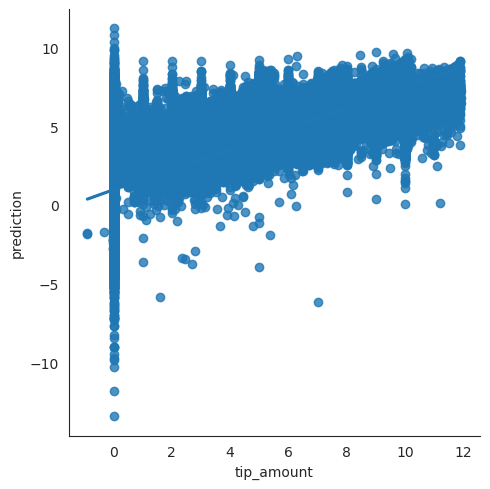

In [73]:
# Visualize regression results

# The Spark dataframe test_results holds the original 'tip' as well as the 'prediction'
# Select and convert to a Pandas dataframe
df = test_results.select('tip_amount','prediction').toPandas()

# Set the style for Seaborn plots
sns.set_style("white")
 
# Create a relationship plot between tip and prediction
sns.lmplot(x='tip_amount', y='prediction', data=df)

In [74]:
# Save the best model
model_path = "gs://my-bigdata-project-cm/models/taxi_tip_linear_regression_model_v3_2023_!2"
bestModel.write().overwrite().save(model_path)

# residuals = bestModel.stages[3].residuals
# test_results.residuals

df = test_results.select('tip_amount','prediction').toPandas()
df['residuals'] = df['tip_amount'] - df['prediction']

# Set the style for Seaborn plots
sns.set_style("white")
 
# Create a relationship plot between tip and prediction
sns.regplot(x = 'prediction', y = 'residuals', data = df, scatter = True, color = 'red') 

# TODO: Add more visualizations for Regression performance metrics
# Loop through the features to extract the original column names. Store in the var_index dictionary
var_index = dict()
for variable_type in ['numeric', 'binary']:
    for variable in test_results.schema["features"].metadata["ml_attr"]["attrs"][variable_type]:
         print("Found variable:", variable)
         idx = variable['idx']
         name = variable['name']
         var_index[idx] = name      # Add the name of the column to the dictionary

# Loop through all of the variables found and print out the associated coefficients
for i in range(len(var_index)):
    print(i, var_index[i], coeff[i])

# Close connection to Spark
spark.stop()